<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

     |████████████████████████████████| 1.3 MB 9.5 MB/s 
     |████████████████████████████████| 600 kB 7.8 MB/s 
     |████████████████████████████████| 766 kB 10.6 MB/s 


In [2]:
# Download font data
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2021-12-08 10:28:53--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  67.4MB/s    in 1.7s    

2021-12-08 10:28:55 (67.4 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
all_words = chain.from_iterable(C.category_split().values())
# Tagger = RadicalSemanticTagger(all_words=all_words, bigram=False)  # Use unigram feature only
Tagger = RadicalSemanticTagger(all_words=all_words, bigram=True)
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

In [44]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.739130,0.472222,0.576271,36.000000
B 物,0.536842,0.708333,0.610778,72.000000
C 時空,0.666667,0.111111,0.190476,18.000000
D 抽象事物,0.307692,0.230769,0.263736,52.000000
E 特徵,0.400000,0.629630,0.489209,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.454545,0.384615,0.416667,13.000000
H 活動,0.414013,0.730337,0.528455,89.000000
I 現象與狀態,0.000000,0.000000,0.000000,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


In [ ]:
# np.exp(model.feature_log_prob_)

## Feature Importance: Permutation Importance

In [45]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='micro'),
    'precision': make_scorer(precision_score, average='micro'),
    'accuracy': 'accuracy',
    'f1': 'f1_micro',
}
imps = permutation_importance(model, X_train, y_train, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)
# imps2 = permutation_importance(model, X_test, y_test, scoring='accuracy',  #scoring, #['f1_micro', 'accuracy'],
#                               n_repeats=2, n_jobs=None, random_state=100)

In [47]:
imps['recall'].importances_mean[-10:]

array([0.001 , 0.004 , 0.0025, 0.0045, 0.0015, 0.002 , 0.    , 0.0005,
       0.001 , 0.    ])

In [48]:
imps['f1'].importances_mean[-10:]

array([0.001 , 0.004 , 0.0025, 0.0045, 0.0015, 0.002 , 0.    , 0.0005,
       0.001 , 0.    ])

In [8]:
imps['precision']['importances'][0]

array([0.01168224, 0.0046729 ])

In [28]:

# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error', random_state=100)
results2 = permutation_importance(model, X, y, scoring='r2', random_state=100)

In [42]:
y

array([-8.42877859e+01, -9.94927008e+01,  1.05787034e+01,  5.37899294e+01,
       -3.70135471e+00,  3.75987136e+01, -1.35735590e+02,  9.35036987e+01,
       -1.03941968e+02,  1.41989579e+01,  1.12479751e+02,  3.00996991e+02,
        1.09526570e+01, -1.07835903e+02,  3.77182129e+01,  1.54366306e+02,
       -4.96393292e+01,  6.23171752e+01, -2.55567671e+02,  4.13245345e+01,
       -1.23446014e+01, -6.10173687e+01,  1.70252877e+02,  1.14872670e+01,
       -3.20300581e+01, -7.01207608e+01,  2.38563440e+01, -1.35524167e+02,
       -9.41054198e+01, -5.91991022e+01, -1.28756571e+02, -2.74040879e+02,
       -1.04228021e+02,  2.25645580e+01,  6.68745459e+01, -1.65001206e+02,
       -3.26368058e+02, -8.41699009e+01, -1.40487772e+02, -1.13560037e+02,
       -8.21439461e+01, -7.06317277e+01,  5.87671092e+01, -1.30319586e+02,
       -1.79488620e+01, -4.33391987e+01,  4.15431377e+02,  1.64720491e+02,
       -2.21775008e+01, -6.46293437e+01, -5.17193029e+01,  3.75124689e+02,
       -1.18336852e+02,  

In [29]:
results.importances_mean[:5]

array([ 227.24763231,  315.65309037,  129.38436286,   36.73901427,
       9738.34746025])

In [30]:
results2.importances_mean[:5]

array([0.01340679, 0.01862239, 0.00763321, 0.00216747, 0.57452715])

In [32]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])
df_importance

,accuracy,f1,precision,recall
NULL,9.112150e-03,9.112150e-03,9.112150e-03,9.112150e-03
人,-7.009346e-04,-7.009346e-04,-7.009346e-04,-7.009346e-04
人倫關係,2.336449e-03,2.336449e-03,2.336449e-03,2.336449e-03
人體內部,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
人體四肢,4.906542e-03,4.906542e-03,4.906542e-03,4.906542e-03
...,...,...,...,...
顏色_生活器物,-5.551115e-18,-5.551115e-18,-5.551115e-18,-5.551115e-18
顏色_禮樂,-1.168224e-03,-1.168224e-03,-1.168224e-03,-1.168224e-03
顏色_穿著器物,-5.551115e-18,-5.551115e-18,-5.551115e-18,-5.551115e-18
顏色_野獸,2.102804e-03,2.102804e-03,2.102804e-03,2.102804e-03


In [38]:
df_importance[df_importance.recall > 0]

,accuracy,f1,precision,recall
NULL,0.009112,0.009112,0.009112,0.009112
人倫關係,0.002336,0.002336,0.002336,0.002336
人體四肢,0.004907,0.004907,0.004907,0.004907
人體性質,0.000701,0.000701,0.000701,0.000701
人體精神,0.003738,0.003738,0.003738,0.003738
...,...,...,...,...
顏色_性質,0.000467,0.000467,0.000467,0.000467
顏色_植物,0.000467,0.000467,0.000467,0.000467
顏色_無生命,0.001168,0.001168,0.001168,0.001168
顏色_生命性質,0.000234,0.000234,0.000234,0.000234


In [35]:
df_importance[df_importance > 0].dropna(axis=0, how='all')

,accuracy,f1,precision,recall
NULL,0.009112,0.009112,0.009112,0.009112
人倫關係,0.002336,0.002336,0.002336,0.002336
人體四肢,0.004907,0.004907,0.004907,0.004907
人體性質,0.000701,0.000701,0.000701,0.000701
人體精神,0.003738,0.003738,0.003738,0.003738
...,...,...,...,...
顏色_性質,0.000467,0.000467,0.000467,0.000467
顏色_植物,0.000467,0.000467,0.000467,0.000467
顏色_無生命,0.001168,0.001168,0.001168,0.001168
顏色_生命性質,0.000234,0.000234,0.000234,0.000234


In [ ]:
df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [ ]:
from copy import deepcopy

scoreDiff = {}
rmFeat = []
for col in X_train.columns:
    X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(val - baseScore['accuracy'])
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                if 'support' in stat: continue
                k = f"{cls}_{stat}"
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(val - base_val)

In [ ]:
# Important features: Decrease acc. (neg. val) after removal
df = pd.DataFrame(scoreDiff, index=rmFeat)

# df.sort_values(by=['A 人_f1-score'], ascending=True).head(10)
# df_norm = (df-df.min())/(df.max()-df.min())
# df_norm
# Unimportant features (by amount of accuracy decrease)
# df.sort_values(by=['accuracy'], ascending=True).head(10)
# df[df.accuracy < 0]

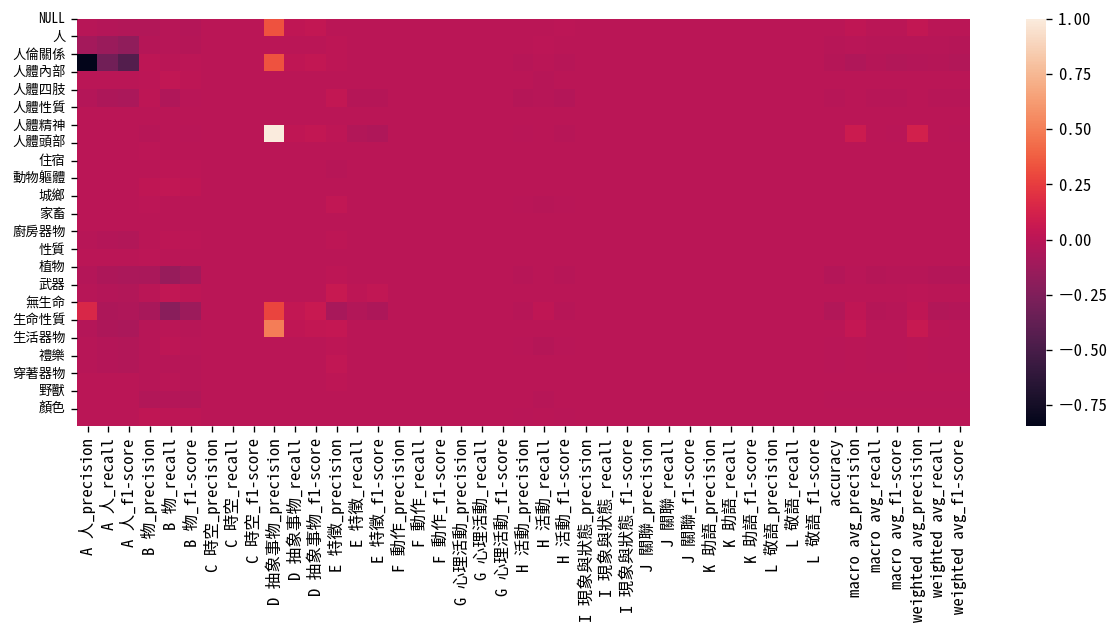

In [ ]:
plt.figure(figsize=(12, 4.5), dpi=120)

ax = sns.heatmap(df, xticklabels=True)
ax.set_yticks(range(df.shape[0])) # <--- set the ticks first
ax.set_yticklabels(df.index, fontsize=8)
# ax.set_xticks(range(df.shape[1])) # <--- set the ticks first
# ax.set_xticklabels(df.columns, fontsize=8)
plt.show()

## ToDo

Add one bigram to see performance increase

## Heatmap

In [ ]:
# Naive Bayes Posterior: P(X_i|y)
#mat = np.exp(model.feature_log_prob_).T
mat = model.feature_log_prob_.T
mat = pd.DataFrame(mat, index=DTM.features, columns=model.classes_).T
mat

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
A 人,-2.376655,-2.235395,-2.059621,-5.195376,-2.554878,-4.968077,-4.147455,-2.779667,-3.018277,-5.886691,-3.632131,-3.702643,-5.314882,-3.422171,-3.031437,-3.785313,-2.507358,-2.287746,-3.508407,-4.270666,-3.331255,-3.723537,-5.029154
B 物,-2.825967,-3.618996,-3.290451,-4.139421,-2.668580,-5.786956,-4.844553,-3.048141,-3.152344,-4.105586,-3.325587,-3.624696,-4.062039,-3.411256,-2.000196,-3.853920,-1.664090,-3.290896,-3.587636,-4.881086,-2.789183,-2.848255,-3.762662
C 時空,-2.060038,-2.885582,-3.475231,-6.888243,-2.957646,-6.049781,-5.044695,-3.060124,-3.071231,-5.499798,-2.689217,-5.343964,-5.154269,-3.564002,-2.322321,-3.507384,-1.443196,-2.680739,-4.477548,-4.527466,-3.287676,-4.460097,-4.129516
D 抽象事物,-2.137212,-2.920629,-3.527319,-4.349630,-2.495929,-5.350698,-3.081364,-2.945896,-3.262168,-5.107369,-3.031534,-3.844411,-4.752533,-3.604164,-2.500698,-3.349826,-1.966092,-3.015748,-3.578053,-3.602216,-3.070914,-3.861297,-3.833925
E 特徵,-2.202109,-3.062194,-3.674641,-5.105987,-2.464344,-5.862133,-3.247812,-2.861097,-2.984583,-5.185950,-3.429426,-3.805003,-4.471981,-3.573579,-2.587045,-3.557557,-1.739036,-2.757485,-3.804742,-4.205354,-3.206892,-3.516845,-3.622910
F 動作,-2.547787,-2.900187,-4.992522,-7.947467,-1.257359,-4.118118,-4.816979,-2.337786,-3.006686,-4.332575,-4.519806,-3.916261,-4.431405,-3.983130,-3.258398,-2.988487,-2.388835,-2.699204,-3.786233,-4.144894,-3.748497,-3.987854,-6.250042
G 心理活動,-2.012486,-3.160328,-4.160232,-4.848871,-2.631421,-5.330984,-1.711773,-2.633997,-3.538217,-5.043825,-3.984684,-3.727024,-5.912851,-4.347825,-3.552218,-3.551174,-1.604313,-3.073344,-3.853792,-4.398411,-4.487959,-3.841791,-5.008219
H 活動,-2.228500,-2.777878,-3.917055,-5.557865,-1.872390,-4.516529,-4.037551,-2.961262,-3.299044,-4.946404,-3.586314,-3.783447,-3.820124,-3.487162,-2.859562,-3.137638,-2.063424,-2.986547,-3.140643,-3.574716,-3.251185,-3.662254,-4.466976
I 現象與狀態,-2.191941,-3.038063,-3.686735,-5.008289,-2.018702,-6.156962,-3.822508,-2.825491,-3.290864,-5.420264,-3.407158,-3.987643,-4.069795,-3.590796,-2.826944,-3.366620,-1.684610,-2.968462,-3.715589,-3.586233,-3.223765,-3.863165,-4.500293
J 關聯,-2.225884,-2.736101,-3.634023,-5.430471,-1.916247,-5.483044,-3.375546,-2.662666,-3.356664,-4.113481,-3.193194,-3.854332,-4.428500,-3.921830,-2.793016,-3.079801,-1.921470,-2.776853,-4.005211,-4.651118,-3.518181,-4.278557,-4.726978


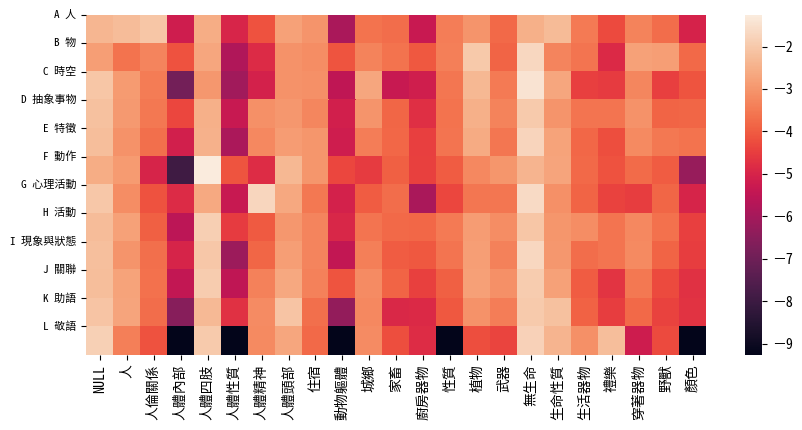

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()
# ax = sns.heatmap(tf_idf_mat.toarray(), linewidth=0.5)
# plt.imshow(mat, cmap='hot', interpolation='nearest')

In [ ]:
# Tfidf matrix
DTM = DocumentTermMatrix(Tagger, C, level=1)
mat = pd.DataFrame(DTM.np.T, index=DTM.features, columns=DTM.df_tgt.lev1).T
# mat

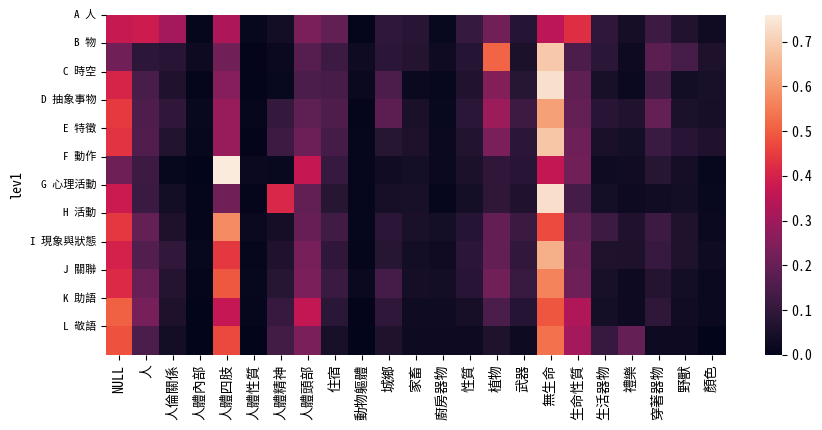

In [ ]:
plt.figure(figsize=(10, 4.5), dpi=100)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=8)
plt.show()